# Setup for Colab

In [ ]:
!git clone https://github.com/zrmor/inverse_problem.git

%pip install pytorch_lightning python-dotenv

!python /content/inverse_problem/code/functions.py
!python /content/inverse_problem/code/models.py

import sys
sys.path.append('/content/inverse_problem/code')

# Initial setup

In [1]:
import os
import numpy as np
import seaborn as sns
from getpass import getpass
from dotenv import load_dotenv
import matplotlib.pyplot as plt

import wandb
import pytorch_lightning as pl
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from models import CNNClassifier, MatrixDataset

# Load and prepare data

In [2]:
# Load data
data_path = "../data/"

all_C = np.load(data_path + 'all_C.npy') # 1326 input matrices of size 30x30
# nMF_label = np.load(data_path + 'nMF_labels.npy') # 1326 output labels (0 or 1)
# kmeans_label = np.load(data_path + 'KMeans_labels_k3.npy') # 1326 output labels (0, 1 or 2)
kmeans_label = np.load(data_path + 'KMeans_labels_k4.npy') # 1326 output labels (0, 1, 2 or 3)

print(f"Number of C and kmeans labels:\n {len(all_C)}, {len(kmeans_label)}\n")

Number of C and kmeans labels:
 1326, 1326



In [3]:
# Remove C with zero kmean labels 
non_zero_indices = np.where(kmeans_label != 0)[0]
all_C = all_C[non_zero_indices]
kmeans_label = kmeans_label[non_zero_indices]

print(f"Number of Cs and labels after removing those with kmeans zero labels:\n {len(all_C)}, {len(kmeans_label)}\n")

Number of Cs and labels after removing those with kmeans zero labels:
 1325, 1325



In [4]:
# Replace values in kmeans_label 
kmeans_label[kmeans_label == 1] = 0  # Replace 1 with 0
kmeans_label[kmeans_label == 2] = 1  # Replace 2 with 1
kmeans_label[kmeans_label == 3] = 2  # Replace 3 with 2

print(f"Updated kmeans_label: {np.unique(kmeans_label, return_counts=True)}")

Updated kmeans_label: (array([0, 1, 2], dtype=int32), array([407, 201, 717]))


In [5]:
class_0_C = all_C[kmeans_label == 0] 
class_1_C = all_C[kmeans_label == 1] 
class_2_C = all_C[kmeans_label == 2] 

print(f"Number of input matrices with kmeans label 0: {class_0_C.shape[0]}")
print(f"Number of input matrices with kmeans label 1: {class_1_C.shape[0]}")
print(f"Number of input matrices with kmeans label 2: {class_2_C.shape[0]}")

Number of input matrices with kmeans label 0: 407
Number of input matrices with kmeans label 1: 201
Number of input matrices with kmeans label 2: 717


# Training the Model

### Find the best params

In [ ]:
best_params_global = None

# Load environment variables from .env file
load_dotenv()

# Get my API key from environment variable first
wandb_key = os.getenv('WANDB_API_KEY')

# If not found in environment, prompt user
if not wandb_key:
    wandb_key = getpass("Enter your Weights & Biases API key: ")

wandb.login(key=wandb_key)

# Define sweep configuration
sweep_config = {
    'method': 'grid', 
    'name': 'sweep',
    'metric': {
        'goal': 'maximize',
        'name': 'val_acc'
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-5]
        },
        'conv_channels': {
            'values': [[1, 32, 64, 128]]
        },
        'fc_units': {
            # 'values': [[1152, 128, 2]]
            'values': [[1152, 128, 3]]
        },
        'dropout_rate': {
            'values': [0.5]
        },
        'batch_size': {
            'values': [128]
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_config, project="inverse_problem")

# Function to find the best parameters using kfold validation 
def find():
    
    wandb.init()
    # Get sweep parameters
    config = wandb.config
     
    global best_params_global
    
    # First split into train+val and test sets (80-20 split)
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        all_C, kmeans_label, test_size=0.2, random_state=42, stratify=kmeans_label
    )

    # K-fold setup for cross-validation on training data
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search with k-fold cross validation
    best_val_acc = 0

    print("Data split sizes:")
    print(f"Train + Validation: {len(X_trainval)} samples")
    print(f"Test: {len(X_test)} samples\n")

    print("Starting grid search with k-fold cross validation")

    # K-fold cross validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_trainval)):
        print(f"\nFold {fold+1}/{kfold.n_splits}")
        
        # Prepare data for this fold
        X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]
        
        train_dataset = MatrixDataset(X_train, y_train)
        val_dataset = MatrixDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
        
        # Initialize model and trainer
        model = CNNClassifier(
            learning_rate=config.learning_rate,
            conv_channels=config.conv_channels,
            fc_units=config.fc_units,
            dropout_rate=config.dropout_rate
        )
        
        checkpoint_callback = ModelCheckpoint(
            monitor='val_acc',
            dirpath='checkpoints/',
            filename=f'fold{fold}_lr{config.learning_rate:.4f}_conv{config.conv_channels}_fc{config.fc_units}_dropout{config.dropout_rate:.2f}_batch{config.batch_size}.ckpt',
            save_top_k=1,
            mode='max'
        )
        
        trainer = pl.Trainer(
            max_epochs=100,
            logger=WandbLogger(project="inverse_problem"),
            callbacks=[checkpoint_callback],
            accelerator='auto',
            log_every_n_steps=1
        )

        # Train model
        print("Training model...")
        trainer.fit(model, train_loader, val_loader)
        
        fold_score = checkpoint_callback.best_model_score.item()
        print(f"Fold {fold+1} best validation accuracy: {fold_score:.4f}")

        # Update best parameters if necessary
        if fold_score > best_val_acc:
            best_val_acc = fold_score
            best_params_global = {
                'learning_rate': config.learning_rate,
                'conv_channels': config.conv_channels,
                'fc_units': config.fc_units,
                'dropout_rate': config.dropout_rate,
                'batch_size': config.batch_size
            }
            print("\n🌟 New best model found!")
            print(f"Best validation accuracy so far: {best_val_acc:.4f}")

    wandb.finish()
    print("\nFinished wandb run for kfold validation.")

# Start the sweep for kfold validation
wandb.agent(sweep_id, function=find, count=1) 
wandb.finish()

### Final training on the whole dataset with the best params

In [8]:
# Best params
best_params_global = {
        'learning_rate': 1e-5,
        'conv_channels': [1, 32, 64, 128],
        # 'fc_units': [1152, 128, 2],
        'fc_units': [1152, 128, 3],
        'dropout_rate': 0.5,
        'batch_size': 128
        }

In [9]:
def final_training(best_params_global):

    global y_pred, y_true

    X_trainval, X_test, y_trainval, y_test = train_test_split(
            all_C, kmeans_label, test_size=0.2, random_state=42, stratify=kmeans_label
        )

    print("Data split sizes:")
    print(f"Train: {len(X_trainval)} samples")
    print(f"Test: {len(X_test)} samples\n")

    print("\nTraining final model with best parameters...")
    final_train_dataset = MatrixDataset(X_trainval, y_trainval)
    final_test_dataset = MatrixDataset(X_test, y_test)

    final_train_loader = DataLoader(final_train_dataset, batch_size=best_params_global['batch_size'], shuffle=True)
    final_test_loader = DataLoader(final_test_dataset, batch_size=best_params_global['batch_size'])

    final_model = CNNClassifier(
        learning_rate=best_params_global['learning_rate'],
        conv_channels=best_params_global['conv_channels'],
        fc_units=best_params_global['fc_units'],
        dropout_rate=best_params_global['dropout_rate']
    )

    # Initialize wandb with a relevant run name
    
    run_name = f"Final_Training_lr{best_params_global['learning_rate']}_conv{best_params_global['conv_channels']}_fc{best_params_global['fc_units']}_batch{best_params_global['batch_size']}_dropout{best_params_global['dropout_rate']}"
    wandb.init(project="inverse_problem", name=run_name)

    final_trainer = pl.Trainer(
        max_epochs=100,
        logger=WandbLogger(project="inverse_problem"),
        accelerator='auto'
    )

    # Train the final model
    final_trainer.fit(final_model, final_train_loader)

    # Evaluate on test set
    test_results = final_trainer.test(final_model, final_test_loader)

    # Log final test accuracy to wandb
    wandb.log({"final_test_accuracy": test_results[0]['test_acc']})

    # Get predictions and true labels
    y_pred = final_model.predict(final_test_loader)  
    y_true = y_test  # True labels

    print(f"\nFinal test accuracy: {test_results[0]['test_acc']:.4f}")

    wandb.finish()
    print("\nFinished wandb run")

final_training(best_params_global) 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Data split sizes:
Train: 1060 samples
Test: 265 samples


Training final model with best parameters...


wandb: Currently logged in as: zrmor (personlich). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.964     Total estimated model params size (MB)
20 

Epoch 99: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s, v_num=ok41]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:02<00:00,  4.01it/s, v_num=ok41]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9358490705490112
        test_loss           0.18368029594421387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final test accuracy: 0.9358


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
final_test_accuracy,▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▁▁▂▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇███████████████
train_acc_step,▁▂▃▅▅▇▆▇▆▇▇▇██▇▇█▅
train_loss_epoch,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▆▅▅▄▄▃▃▃▂▂▁▂▁▁▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch,100
final_test_accuracy,0.93585



Finished wandb run


# Model Evaluation

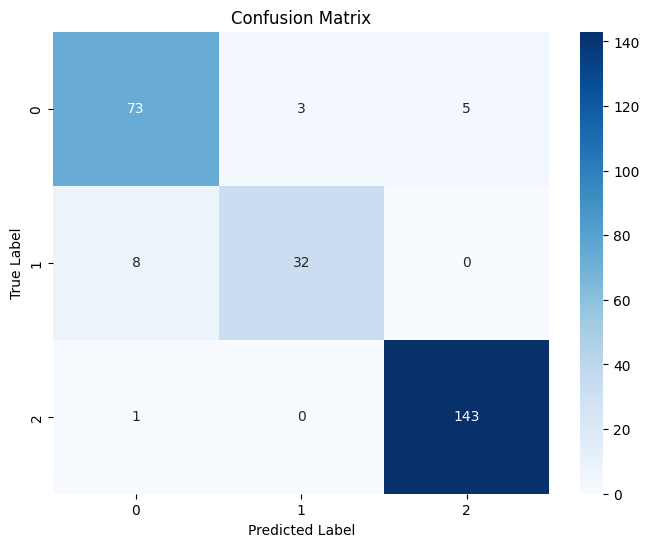

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.savefig('../docs/k2means_confusion.png')
plt.savefig('../docs/k3means_confusion.png')
plt.show()

### For binary class

In [13]:
# ROC Curves
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../docs/k2means_roc.png')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

ap_score = average_precision_score(y_true, y_pred)
print(f"Average Precision score: {ap_score:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (AP = %0.2f)' % ap_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left") 
plt.savefig('../docs/k2means_pr.png')
plt.show()


### For multi class

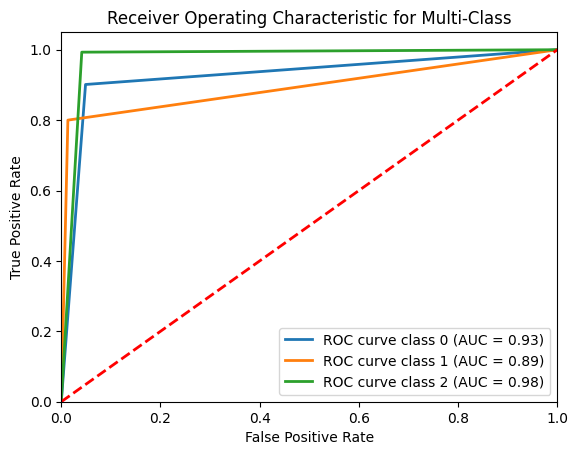

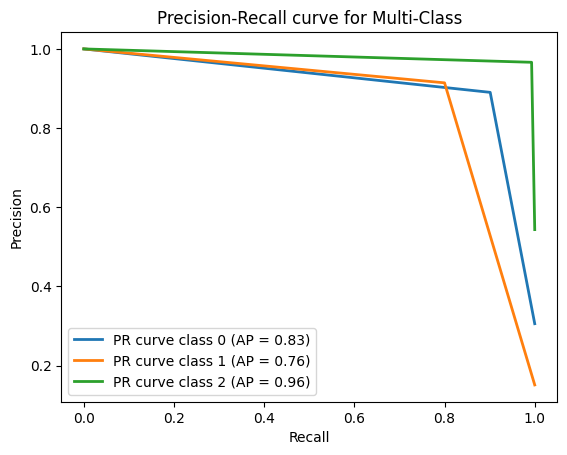

In [12]:
# ROC Curve
# Binarize the output for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # For each class
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('../docs/k3means_roc.png')
plt.show()

# Precision-Recall Curve
precision = dict()
recall = dict()
ap_score = dict()
for i in range(3):  # For each class
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    ap_score[i] = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='PR curve class {0} (AP = {1:0.2f})'.format(i, ap_score[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Multi-Class')
plt.legend(loc="lower left") 
plt.savefig('../docs/k3means_pr.png')
plt.show()